In [94]:
import os
import numpy as np
import logging
from datetime import datetime
import csv
import pandas as pd
import operator
import re
import multiprocessing
num_cpus = multiprocessing.cpu_count()

# NLP related imports
import string

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

#Feature selection imports
from sklearn.feature_selection import mutual_info_classif

# Feature Construction pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_validate, KFold


import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns

from sklearn.base import clone
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from nbsvm import NBSVM


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/gchowdhary92/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/gchowdhary92/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/gchowdhary92/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
logger = logging.getLogger(__name__)
np.random.seed(2019)

log_path = datetime.now().strftime('./logs/%Y-%m-%d-%H-%M-%S.log')
logging.basicConfig(filename=log_path, level=logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler())

#### Loading Data from Memory

In [70]:
def load_data(dp):
    x = []
    for fn in sorted(os.listdir(dp), key=lambda y: int(y[:-4])):
        with open('{dp}{fn}'.format(dp=dp, fn=fn), 'r') as f:
            x.append(f.read())
    return x

logger.info('[{t}] Start'.format(t=datetime.now()))

x_tr_pos = np.array(load_data('./dataset/train/pos/'), dtype=np.str)
x_tr_neg = np.array(load_data('./dataset/train/neg/'), dtype=np.str)
x_tr = np.concatenate((x_tr_pos, x_tr_neg), axis=0)
y_tr = np.concatenate((np.ones_like(x_tr_pos, dtype=np.float64), np.zeros_like(x_tr_neg, dtype=np.float64)), axis=0)
x_ts = np.array(load_data('./dataset/test/'), dtype=np.str)

del x_tr_pos
del x_tr_neg

logger.info('[{t}] Finish'.format(t=datetime.now()))

[2019-02-21 05:47:35.092801] Start
[2019-02-21 05:47:39.087941] Finish


#### String Preprocessing

In [5]:
def preprocessor(s):
    s = s.lower()
    s = s.replace('<br /><br />', ' ')
    s = s.replace('-', ' ')
    s = s.replace('/', ' ')
    for ws in string.whitespace:
        s.replace(ws, ' ')
    s = s.translate(s.maketrans('', '', string.punctuation))
    s = s.translate(s.maketrans('', '', string.digits))
    s = ''.join(filter(lambda x: x in string.printable, s))
    return s


def tokenizer(s):
    wl = WordNetLemmatizer()
    st = SnowballStemmer('english', ignore_stopwords=True)
    ts = word_tokenize(s, 'english')
    ts = list(filter(lambda x: x not in stopwords.words('english'), ts))
    ts = list(map(lambda x: wl.lemmatize(x), ts))
    ts = list(map(lambda x: st.stem(x), ts))
    return ts

token_pattern = r'\w+|[%s]' % string.punctuation

### Statistical text based features

In [6]:
train = pd.DataFrame({ 'text' : x_tr , 'label' : y_tr})

#### count_words

In [7]:
train.loc[train.index.tolist(),'word_count'] = train['text'].apply(lambda x: len(str(x).split()))
train.head()

,text,label,word_count
0,Bromwell High is a cartoon comedy. It ran at t...,1.0,140
1,"If you like adult comedy cartoons, like South ...",1.0,113
2,Bromwell High is nothing short of brilliant. E...,1.0,114
3,FUTZ is the only show preserved from the exper...,1.0,237
4,Although I didn't like Stanley & Iris tremendo...,1.0,122


#### count_capital_words

In [8]:
train.loc[train.index.tolist(),'words_uppcase'] = train['text'].apply(lambda x : len([x for x 
                                                                             in x.split() if x.isupper()]))
train.head()

,text,label,word_count,words_uppcase
0,Bromwell High is a cartoon comedy. It ran at t...,1.0,140,7
1,"If you like adult comedy cartoons, like South ...",1.0,113,2
2,Bromwell High is nothing short of brilliant. E...,1.0,114,0
3,FUTZ is the only show preserved from the exper...,1.0,237,3
4,Although I didn't like Stanley & Iris tremendo...,1.0,122,5


#### count_exclaim_ques_marks

In [9]:
train.loc[train.index.tolist(),'count_marks'] = train['text'].apply(lambda x : len(re.findall(r'!|\?', x)))
train.head()

,text,label,word_count,words_uppcase,count_marks
0,Bromwell High is a cartoon comedy. It ran at t...,1.0,140,7,1
1,"If you like adult comedy cartoons, like South ...",1.0,113,2,1
2,Bromwell High is nothing short of brilliant. E...,1.0,114,0,1
3,FUTZ is the only show preserved from the exper...,1.0,237,3,0
4,Although I didn't like Stanley & Iris tremendo...,1.0,122,5,0


#### Profanity

In [10]:
LOAD_PROF_DISK =True

if not LOAD_PROF_DISK:
        # Reading the already stored profanity words file
    with open('./files/profanity.csv', 'r') as f:
        reader = csv.reader(f)
        profanity_list = [w[0] for w in reader]
    profanity_dict = dict.fromkeys(profanity_list, True)

    # for stemming the word to its root
    st = PorterStemmer()
    train.loc[train.index.tolist(),'num_profanity'] = train['text'].apply(lambda x : 
                                                       len([ word for word in x.split() if st.stem(word) in profanity_dict]))
else:
    train = pd.read_csv('./files/train_prof.csv')
    
train.head()

,text,label,word_count,words_uppcase,count_marks,num_profanity
0,Bromwell High is a cartoon comedy. It ran at t...,1.0,140,7,1,2
1,"If you like adult comedy cartoons, like South ...",1.0,113,2,1,4
2,Bromwell High is nothing short of brilliant. E...,1.0,114,0,1,1
3,FUTZ is the only show preserved from the exper...,1.0,237,3,0,4
4,Although I didn't like Stanley & Iris tremendo...,1.0,122,5,0,0


#### Visualizing how different features are stastical text features are realted to labels 

In [11]:
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('label')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, col='label', height=5, hue='label', palette="PuBuGn_d")
    g = g.map(sns.distplot, col, kde=False, norm_hist=True, bins=bins)
    plt.show()

Descriptive stats for words_uppcase
-----------------------------------
         count     mean       std  min  25%  50%  75%    max
label                                                       
0.0    12500.0  5.16712  5.831843  0.0  2.0  4.0  7.0  151.0
1.0    12500.0  4.53352  5.583505  0.0  1.0  3.0  6.0  122.0


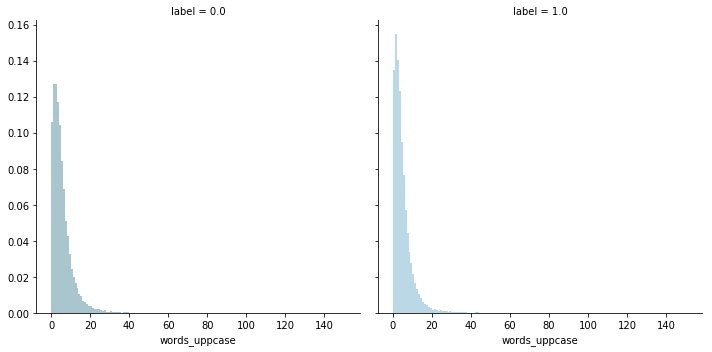

In [12]:
show_dist(train,'words_uppcase')

Descriptive stats for word_count
--------------------------------
         count       mean         std   min    25%    50%    75%     max
label                                                                   
0.0    12500.0  230.86784  166.663126  10.0  128.0  174.0  278.0  1522.0
1.0    12500.0  236.70656  180.485743  12.0  125.0  174.0  291.0  2470.0


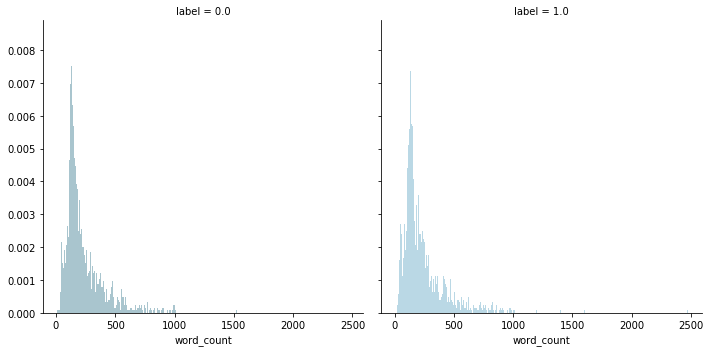

In [13]:
show_dist(train,'word_count')

Descriptive stats for num_profanity
-----------------------------------
         count     mean       std  min  25%  50%  75%   max
label                                                      
0.0    12500.0  2.23344  2.926778  0.0  0.0  1.0  3.0  36.0
1.0    12500.0  1.76696  2.498422  0.0  0.0  1.0  2.0  34.0


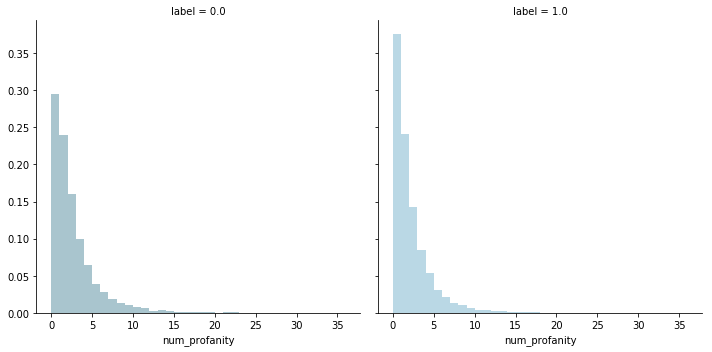

In [14]:
show_dist(train,'num_profanity')

Descriptive stats for count_marks
---------------------------------
         count     mean       std  min  25%  50%  75%    max
label                                                       
0.0    12500.0  1.92680  3.666142  0.0  0.0  1.0  2.0   79.0
1.0    12500.0  1.32504  4.685060  0.0  0.0  0.0  2.0  282.0


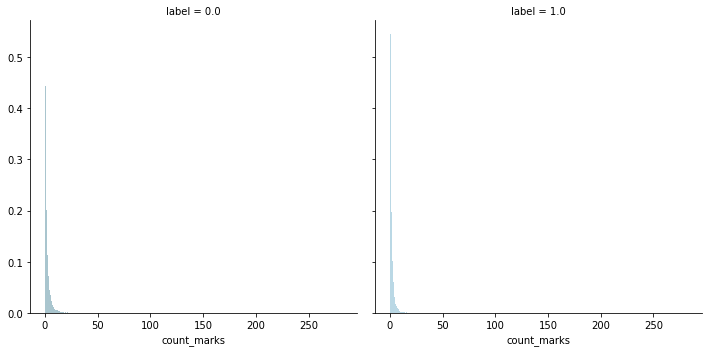

In [15]:
show_dist(train,'count_marks')

**Conclusion** : Stastical text based features donot provide a decent measure to differentiate good comments from bad ones.

In [ ]:
# Removing the datagram from memory
del train

### Vocabulary based Features

#### Calculating feature importance 

In [16]:
LOAD_INFOG_DISK = True
ig_path = './files/info_gain.csv'

if LOAD_INFOG_DISK:
    vocabulary = None
    if os.path.exists(ig_path):
        # Using pandas Dataframe was more effecient on my Machine : Added by Aman
        data = pd.read_csv(ig_path)
        #vocabulary = np.genfromtxt(ig_path, delimiter=',', dtype=np.str)[:, 1].squeeze()
        vocabulary = np.asarray(data['word'], dtype=np.str)
else:
    mi = mutual_info_classif(x_tr, y_tr)
    with open(ig_path, 'w') as f:
        for mi_i, fn_i in sorted(zip(mi, fn), key=lambda x: -x[0]):
            f.write('{mi_i},{fn_i}\n'.format(mi_i=mi_i, fn_i=fn_i))

Vocabulary obtained from feature selection

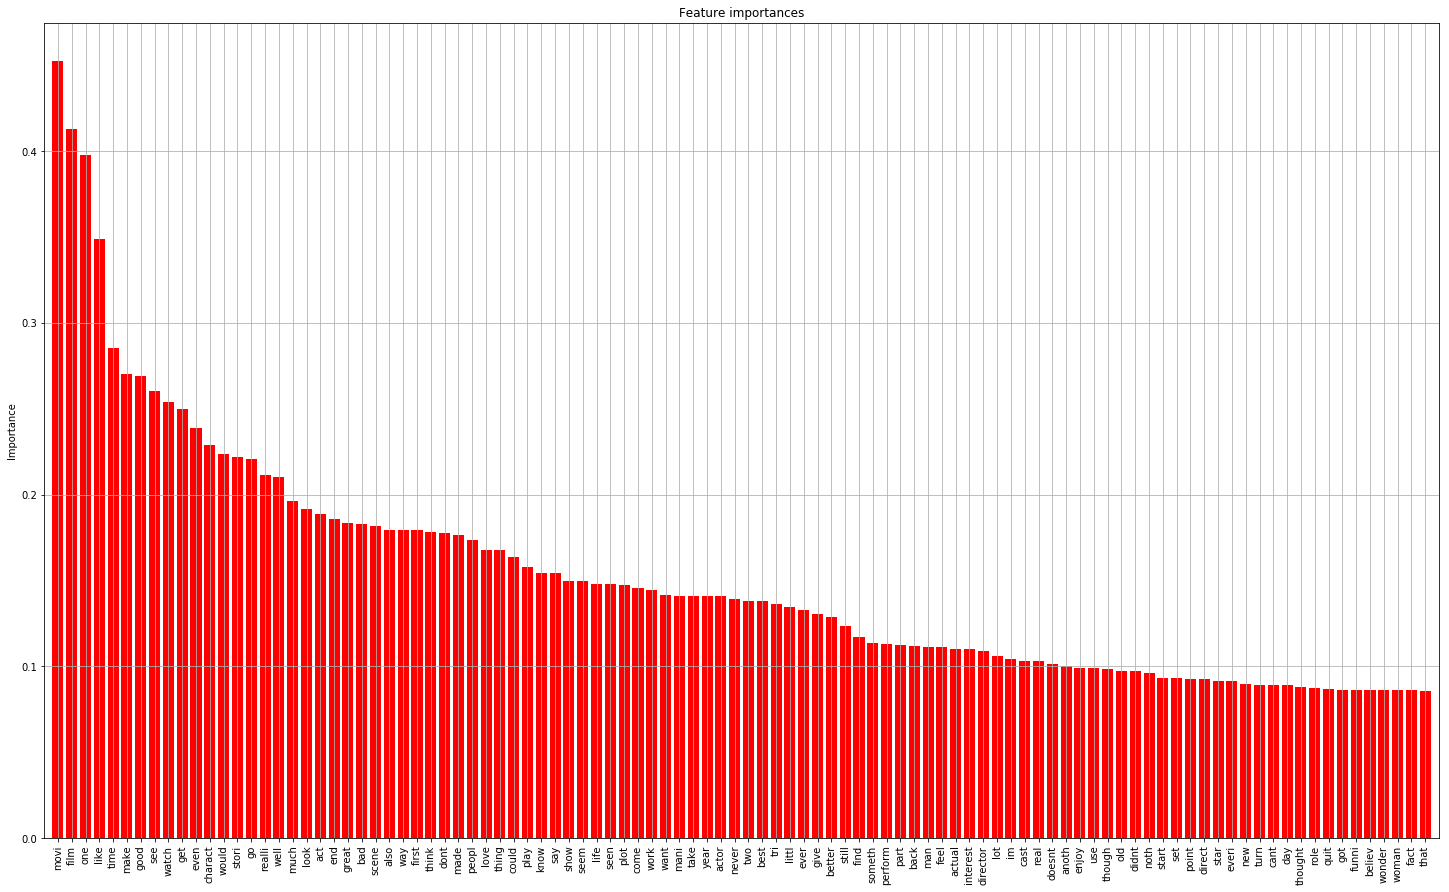

In [17]:
# Preparing variables
importances = data['importance']
feature_names = data['word']
feature_imp_dict = dict(zip(feature_names, importances))
sorted_features = sorted(feature_imp_dict.items(), key=operator.itemgetter(1), reverse=True)

indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure(figsize = (25,15))
plt.title("Feature importances")
plt.bar(range(100), importances[indices[:100]],
       color="r", align="center")
plt.xticks(range(100), feature_names[:100], rotation=90)
plt.xlim([-1, 100])
plt.ylabel('Importance')

plt.grid()
plt.show()


### Constructing Pipelines

#### Binary occurrences

In [71]:
cnt = CountVectorizer(token_pattern=token_pattern,
                      ngram_range=(1, 3),
                      vocabulary=list(set(vocabulary[:50000])),
                      binary=True)

In [72]:
logger.info('[{t}] Start'.format(t=datetime.now()))

x_tr_cnt = cnt.fit_transform(x_tr)
x_ts_cnt = cnt.transform(x_ts)
fn = np.array(cnt.get_feature_names(), dtype=np.str)

logger.info('[{t}] Finish'.format(t=datetime.now()))

[2019-02-21 05:48:39.123228] Start
[2019-02-21 05:49:06.171858] Finish


#### TF-IDF weighting

In [73]:
tf_idf = TfidfVectorizer(preprocessor=preprocessor,
                         tokenizer=tokenizer,
                         ngram_range=(1, 3),
                         vocabulary=list(set(vocabulary[:50000])),
                         binary=True,
                         use_idf=False,
                         smooth_idf=True)

In [74]:
logger.info('[{t}] Start'.format(t=datetime.now()))

x_tr_tf = tf_idf.fit_transform(x_tr)
x_ts_tf = tf_idf.transform(x_ts)
fn = np.array(tf_idf.get_feature_names(), dtype=np.str)

logger.info('[{t}] Finish'.format(t=datetime.now()))

[2019-02-21 05:49:36.536039] Start
[2019-02-21 06:09:38.008328] Finish


In [63]:
print(x_tr_cnt.shape)
print(x_ts_cnt.shape)
print(x_tr_tf.shape)
print(x_ts_tf.shape)

(25000, 4396693)
(25000, 4396693)
(25000, 4396693)
(25000, 4396693)


### Training and Testing with both Pipelines

In [83]:
def k_fold_cross_validation(k, cl, x_tr, y_tr):
    cv = KFold(n_splits=k, shuffle=True)
    cv_s = cross_validate(cl, x_tr, y_tr, cv=cv, scoring='f1', return_train_score=True, verbose=1, n_jobs=-1)
    print('KFold Cross Validation Scores: {cv_s}'.format(cv_s=cv_s, indent=4))
    print('Mean CV Score: {e}'.format(e=sum(cv_s['test_score']) / k))

In [84]:
def predict_test(cl, x_tr, y_tr, x_ts, fn):
    cl.fit(x_tr, y_tr)
    with open('./results/{fn}.csv'.format(fn=fn), 'w') as f:
        f.write('Id,Category\n')
        for i, y_i in enumerate(cl.predict(x_ts)):
            f.write('{i},{y_i}\n'.format(i=i, y_i=int(y_i)))
    return None

#### Testing Pipeline : Binary occurrences

Gaussian Naive Baye's

In [85]:
cl_gnb = GaussianNB()
k_fold_cross_validation(4, clone(cl_gnb), x_tr_cnt.toarray(), y_tr)
#predict_test(cl_gnb, x_tr_cnt.toarray(), y_tr, x_ts_cnt.toarray(), 'gaussian_naive_bayes')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold Cross Validation Scores: {'fit_time': array([23.1663456 , 22.91668105, 22.09961581, 22.27511716]), 'score_time': array([3.88930607, 4.05365634, 4.1651752 , 3.93934965]), 'test_score': array([0.73606299, 0.73584906, 0.74095854, 0.74248927]), 'train_score': array([0.83361433, 0.82973644, 0.83362745, 0.82763622])}
Mean CV Score: 0.7388399651803585


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   43.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   43.2s finished


Bernoulli Naive Baye's

In [86]:
cl_bnb = BernoulliNB()
k_fold_cross_validation(4, clone(cl_bnb), x_tr_cnt.toarray(), y_tr)
#predict_test(cl_bnb, x_tr.toarray(), y_tr, x_ts.toarray(), 'bernoulli_naive_bayes')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold Cross Validation Scores: {'fit_time': array([19.09378767, 20.47525287, 20.33019733, 18.98015451]), 'score_time': array([3.1090734 , 2.80524516, 2.95181155, 3.22289753]), 'test_score': array([0.82497282, 0.81515803, 0.82417054, 0.82223638]), 'train_score': array([0.85689609, 0.85543444, 0.85793279, 0.85920501])}
Mean CV Score: 0.8216344442798762


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   35.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   35.2s finished


In [87]:
cl_lr = LogisticRegression(solver='lbfgs', verbose=1, n_jobs=-1, C=1)
k_fold_cross_validation(4, clone(cl_lr), x_tr_cnt, y_tr)
#predict_test(cl_lr, x_tr, y_tr, x_ts, 'logistic_regression')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold Cross Validation Scores: {'fit_time': array([6.11237574, 6.59618735, 6.31042886, 6.56292892]), 'score_time': array([0.0072732 , 0.0065217 , 0.00717425, 0.00688124]), 'test_score': array([0.82750988, 0.8344519 , 0.82896219, 0.8370637 ]), 'train_score': array([0.95809788, 0.95818095, 0.95750318, 0.95891875])}
Mean CV Score: 0.831996918620772


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.7s finished


In [91]:
cl_ls = LinearSVC(C=0.75, verbose=1)
k_fold_cross_validation(4, clone(cl_ls), x_tr_cnt, y_tr)
#predict_test(cl_ls, x_tr, y_tr, x_ts, 'linear_svc')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold Cross Validation Scores: {'fit_time': array([3.34061527, 3.30873752, 3.50687027, 3.23078084]), 'score_time': array([0.00377607, 0.00369859, 0.00408602, 0.00384951]), 'test_score': array([0.80231996, 0.8014071 , 0.80152067, 0.79567842]), 'train_score': array([0.99173904, 0.99300625, 0.99230029, 0.99182561])}
Mean CV Score: 0.8002315390790173


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.7s finished


In [92]:
kc = KNeighborsClassifier(11, n_jobs=-1)
k_fold_cross_validation(4, clone(kc), x_tr_cnt, y_tr)
#predict_test(kc, x_tr, y_tr, x_ts, 'knn_classifier')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold Cross Validation Scores: {'fit_time': array([0.03574657, 0.03628635, 0.03520155, 0.04452443]), 'score_time': array([8.6254077 , 7.60718489, 7.61338639, 7.98544335]), 'test_score': array([0.70019579, 0.60724685, 0.67176198, 0.70265013]), 'train_score': array([0.74355415, 0.71642276, 0.75780062, 0.74500359])}
Mean CV Score: 0.6704636865399329


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   34.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   34.5s finished


In [95]:
cl_nb_svm = NBSVM()
k_fold_cross_validation(4, clone(cl_nb_svm), x_tr_cnt, y_tr)
#predict_test(cl_nb_svm, x_tr_cnt, y_tr, x_ts, 'nb_svm')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold Cross Validation Scores: {'fit_time': array([1.79750085, 1.51833892, 1.92838335, 1.36713409]), 'score_time': array([0.00397825, 0.00397682, 0.00386357, 0.00412226]), 'test_score': array([0.8436513 , 0.82824366, 0.83151125, 0.8371721 ]), 'train_score': array([0.89914841, 0.90467349, 0.90250934, 0.90234792])}
Mean CV Score: 0.8351445780145694


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.0s finished


#### Testing PIpeline :TF-IDF

In [105]:
cl_gnb = GaussianNB()
k_fold_cross_validation(4, clone(cl_gnb), x_tr_tf.toarray(), y_tr)
#predict_test(cl_gnb, x_tr_cnt.toarray(), y_tr, x_ts_cnt.toarray(), 'gaussian_naive_bayes')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   23.2s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/backend/utils.py:55: UserWarning:

Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/backend/utils.py:55: UserWarning:

Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/backend/utils.py:55: UserWarning:

Failed to kill subprocesses on this platform. Pleaseinstall psutil: https://github.com/giampaolo/psutil

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/externals/loky/backend/utils.py:55: UserWarning:

Failed to kill subprocesses on this platform. Pleaseinstall psutil: http

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

Bernoulli Naive Baye's

In [ ]:
cl_bnb = BernoulliNB()
k_fold_cross_validation(4, clone(cl_bnb), x_tr_tf.toarray(), y_tr)
#predict_test(cl_bnb, x_tr.toarray(), y_tr, x_ts.toarray(), 'bernoulli_naive_bayes')

In [87]:
cl_lr = LogisticRegression(solver='lbfgs', verbose=1, n_jobs=-1, C=1)
k_fold_cross_validation(4, clone(cl_lr), x_tr_tf, y_tr)
#predict_test(cl_lr, x_tr, y_tr, x_ts, 'logistic_regression')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold Cross Validation Scores: {'fit_time': array([6.11237574, 6.59618735, 6.31042886, 6.56292892]), 'score_time': array([0.0072732 , 0.0065217 , 0.00717425, 0.00688124]), 'test_score': array([0.82750988, 0.8344519 , 0.82896219, 0.8370637 ]), 'train_score': array([0.95809788, 0.95818095, 0.95750318, 0.95891875])}
Mean CV Score: 0.831996918620772


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    6.7s finished


In [91]:
cl_ls = LinearSVC(C=0.75, verbose=1)
k_fold_cross_validation(4, clone(cl_ls), x_tr_cnt, y_tr)
#predict_test(cl_ls, x_tr, y_tr, x_ts, 'linear_svc')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold Cross Validation Scores: {'fit_time': array([3.34061527, 3.30873752, 3.50687027, 3.23078084]), 'score_time': array([0.00377607, 0.00369859, 0.00408602, 0.00384951]), 'test_score': array([0.80231996, 0.8014071 , 0.80152067, 0.79567842]), 'train_score': array([0.99173904, 0.99300625, 0.99230029, 0.99182561])}
Mean CV Score: 0.8002315390790173


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    4.7s finished


In [92]:
kc = KNeighborsClassifier(11, n_jobs=-1)
k_fold_cross_validation(4, clone(kc), x_tr_cnt, y_tr)
#predict_test(kc, x_tr, y_tr, x_ts, 'knn_classifier')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold Cross Validation Scores: {'fit_time': array([0.03574657, 0.03628635, 0.03520155, 0.04452443]), 'score_time': array([8.6254077 , 7.60718489, 7.61338639, 7.98544335]), 'test_score': array([0.70019579, 0.60724685, 0.67176198, 0.70265013]), 'train_score': array([0.74355415, 0.71642276, 0.75780062, 0.74500359])}
Mean CV Score: 0.6704636865399329


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   34.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   34.5s finished


In [95]:
cl_nb_svm = NBSVM()
k_fold_cross_validation(4, clone(cl_nb_svm), x_tr_cnt, y_tr)
#predict_test(cl_nb_svm, x_tr_cnt, y_tr, x_ts, 'nb_svm')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


KFold Cross Validation Scores: {'fit_time': array([1.79750085, 1.51833892, 1.92838335, 1.36713409]), 'score_time': array([0.00397825, 0.00397682, 0.00386357, 0.00412226]), 'test_score': array([0.8436513 , 0.82824366, 0.83151125, 0.8371721 ]), 'train_score': array([0.89914841, 0.90467349, 0.90250934, 0.90234792])}
Mean CV Score: 0.8351445780145694


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    2.0s finished


In [106]:
import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)


[('y_tr', 200096),
 ('CountVectorizer', 1464),
 ('LinearSVC', 1464),
 ('LogisticRegression', 1464),
 ('TfidfVectorizer', 1464),
 ('KNeighborsClassifier', 1184),
 ('BernoulliNB', 1056),
 ('GaussianNB', 1056),
 ('KFold', 1056),
 ('NBSVM', 1056),
 ('PorterStemmer', 1056),
 ('SnowballStemmer', 1056),
 ('WordNetLemmatizer', 1056),
 ('clone', 136),
 ('cross_validate', 136),
 ('k_fold_cross_validation', 136),
 ('load_data', 136),
 ('mutual_info_classif', 136),
 ('predict_test', 136),
 ('preprocessor', 136),
 ('show_dist', 136),
 ('tokenizer', 136),
 ('word_tokenize', 136),
 ('token_pattern', 87),
 ('go', 80),
 ('np', 80),
 ('pd', 80),
 ('plt', 80),
 ('sns', 80),
 ('log_path', 79),
 ('ig_path', 70),
 ('cl_bnb', 56),
 ('cl_gnb', 56),
 ('cl_lr', 56),
 ('cl_ls', 56),
 ('cl_nb_svm', 56),
 ('cnt', 56),
 ('kc', 56),
 ('logger', 56),
 ('stopwords', 56),
 ('tf_idf', 56),
 ('x_tr_cnt', 56),
 ('x_tr_tf', 56),
 ('x_ts_cnt', 56),
 ('x_ts_tf', 56),
 ('LOAD_INFOG_DISK', 28),
 ('LOAD_PROF_DISK', 28),
 ('num_

In [104]:
del fn
import gc
gc.collect()

0

6873